In [ ]:
# Standard libraries
import numpy as np
import pandas as pd
import json
from collections import defaultdict, Counter
from tqdm import tqdm

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

Number of actions: 50
Train states shape: (9613, 64)
Train actions shape: (9613,)
Epoch 1/50, Train Loss: 2.7861, Val Loss: 2.5493, Val Acc: 28.29%
Epoch 2/50, Train Loss: 2.3179, Val Loss: 2.2504, Val Acc: 33.61%
Epoch 3/50, Train Loss: 2.0965, Val Loss: 2.1504, Val Acc: 38.48%
Epoch 4/50, Train Loss: 1.9613, Val Loss: 2.0049, Val Acc: 41.43%
Epoch 5/50, Train Loss: 1.8266, Val Loss: 1.8955, Val Acc: 42.39%
Epoch 6/50, Train Loss: 1.6828, Val Loss: 1.6738, Val Acc: 47.00%
Epoch 7/50, Train Loss: 1.5375, Val Loss: 1.5821, Val Acc: 48.46%
Epoch 8/50, Train Loss: 1.4852, Val Loss: 1.5988, Val Acc: 47.96%
Epoch 9/50, Train Loss: 1.4364, Val Loss: 1.5260, Val Acc: 49.08%
Epoch 10/50, Train Loss: 1.4141, Val Loss: 1.4905, Val Acc: 49.96%
Epoch 11/50, Train Loss: 1.3970, Val Loss: 1.4812, Val Acc: 50.42%
Epoch 12/50, Train Loss: 1.3882, Val Loss: 1.4922, Val Acc: 50.08%
Epoch 13/50, Train Loss: 1.3817, Val Loss: 1.4742, Val Acc: 49.54%
Epoch 14/50, Train Loss: 1.3484, Val Loss: 1.4935, Val A

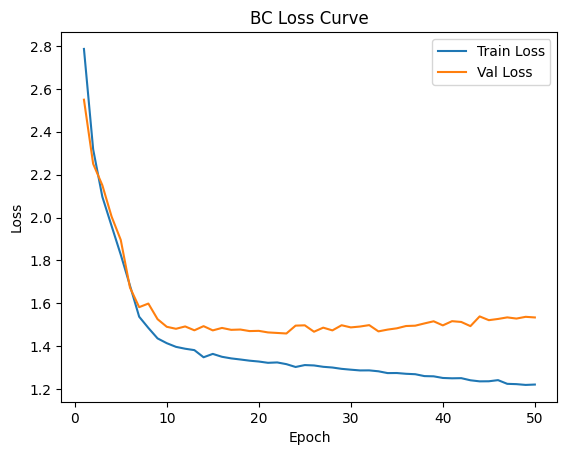

Best validation accuracy: 50.42%


In [ ]:
# Converts numpy arrays to Pytorch tensors for custom dataset
class TutorDataset(Dataset):
    def __init__(self, states, actions):
        self.states = torch.tensor(states, dtype=torch.float32)
        self.actions = torch.tensor(actions, dtype=torch.long)

    def __len__(self):
        return len(self.actions)

    def __getitem__(self, i):
        return self.states[i], self.actions[i]

# FFNN with 2 hidden layers, 256 units each, ReLU activation, 80/20 train/val split
class BCModel(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.net(x)

def prepare_data_for_bc(csv_file_path):
    df = pd.read_csv(csv_file_path)
    state_features = [
        'misconception_type',
        'convo_turn',
        'previous_action_id',
        'listen_to_feedback',
        'problem_progress',
        'progress_delta',
        'correct_solution',
        'next_action_hint_strength'
    ]
    action_column = 'next_action_id'
    df = df.dropna(subset=[action_column])
    df[action_column] = df[action_column].astype(int)
    categorical_features = ['misconception_type', 'previous_action_id', 'listen_to_feedback', 'correct_solution']
    numerical_features = [f for f in state_features if f not in categorical_features]
    for feature in categorical_features:
        df[feature] = df[feature].fillna(-1)
    for feature in numerical_features:
        df[feature] = df[feature].fillna(df[feature].mean() if not df[feature].isna().all() else 0)
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    encoded_features = encoder.fit_transform(df[categorical_features])
    numerical_data = df[numerical_features].values
    states = np.hstack((numerical_data, encoded_features))
    actions = df[action_column].values
    unique_actions = np.unique(actions)
    action_map = {old_id: new_id for new_id, old_id in enumerate(sorted(unique_actions))}
    remapped_actions = np.array([action_map[a] for a in actions])
    train_states, val_states, train_actions, val_actions = train_test_split(
        states, remapped_actions, test_size=0.2, random_state=42
    )
    return train_states, val_states, train_actions, val_actions, len(unique_actions)

def train_bc_model(csv_file_path, epochs=50, batch_size=128, lr=1e-3):
    train_states, val_states, train_actions, val_actions, num_actions = prepare_data_for_bc(csv_file_path)
    print(f"Number of actions: {num_actions}")
    print(f"Train states shape: {train_states.shape}")
    print(f"Train actions shape: {train_actions.shape}")
    train_ds = TutorDataset(train_states, train_actions)
    val_ds = TutorDataset(val_states, val_actions)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size)

    model = BCModel(input_dim=train_states.shape[1], output_dim=num_actions)
    criterion = nn.CrossEntropyLoss()
    opt = optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    val_losses = []

    best_val_acc = 0
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0
        for S, A in train_loader:
            logits = model(S)
            loss = criterion(logits, A)
            opt.zero_grad()
            loss.backward()
            opt.step()
            train_loss += loss.item()
            _, predicted = torch.max(logits.data, 1)
            train_total += A.size(0)
            train_correct += (predicted == A).sum().item()
        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0
        val_total = 0
        val_correct = 0
        with torch.no_grad():
            for S, A in val_loader:
                logits = model(S)
                loss = criterion(logits, A)
                val_loss += loss.item()
                _, predicted = torch.max(logits.data, 1)
                val_total += A.size(0)
                val_correct += (predicted == A).sum().item()
        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        val_acc = 100 * val_correct / val_total
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_bc_model.pt')

        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

    # Plot BC loss curve
    plt.figure()
    plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
    plt.plot(range(1, epochs+1), val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('BC Loss Curve')
    plt.legend()
    plt.show()

    print(f'Best validation accuracy: {best_val_acc:.2f}%')
    return model

if __name__ == "__main__":
    model = train_bc_model("data.csv")


In [ ]:
# stores sequences of state-action-reward transitions (s,a,r,s',done)
class TransitionBuffer:
    def __init__(self):
        self.states = []
        self.actions = []
        self.rewards = []
        self.next_states = []
        self.dones = []

    def push(self, s, a, r, s2, done):
        self.states.append(s)
        self.actions.append(a)
        self.rewards.append(r)
        self.next_states.append(s2)
        self.dones.append(done)

    def __len__(self):
        return len(self.actions)

# converts tabular tutoring data into transitions, encode features, organize data based on convo turns
def build_transition_buffer(
    df: pd.DataFrame,
    reward_fn,
    meta_map: dict,
    orig_to_idx: dict,
    episode_column: str = None
):
    """
    Build a transition buffer for offline RL using a 50-action index map and
    its corresponding metadata map.

    Args:
        df: DataFrame with tutoring data; must contain 'next_action_id' and state features.
        reward_fn: function(prev_state, action_idx, next_state, action_meta) -> reward
        meta_map: nested metadata dict mapping category->strategy->(level->idx) for 50 actions
        orig_to_idx: dict mapping original action IDs -> compact indices (0..49)
        episode_column: optional col to group episodes; if None assumes ordered by 'convo_turn'

    Returns:
        buffer: TransitionBuffer of (state, action_idx, reward, next_state, done)
        orig_to_idx: same dict mapping original IDs -> indices (for model sizing)
    """
    # Flatten meta_map into flat_idx_to_meta
    flat_idx_to_meta = {}
    for cat, strategies in meta_map.items():
        for strat, levels in strategies.items():
            for lvl, idx in levels.items():
                flat_idx_to_meta[idx] = {
                    'category': cat,
                    'strategy': strat,
                    'level': lvl
                }

    # State feature setup
    state_feats = ['misconception_type','convo_turn','previous_action_id',
                   'listen_to_feedback','problem_progress','progress_delta',
                   'correct_solution','next_action_hint_strength']
    cat_feats = ['misconception_type','previous_action_id',
                 'listen_to_feedback','correct_solution']
    num_feats = [f for f in state_feats if f not in cat_feats]

    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    encoder.fit(df[cat_feats])

    # Group episodes
    if episode_column:
        episodes = df.sort_values([episode_column,'convo_turn']).groupby(episode_column)
    else:
        df = df.sort_values('convo_turn')
        df['_tmp_ep'] = 1
        episodes = df.groupby('_tmp_ep')

    buffer = TransitionBuffer()

    # Build transitions
    for _, ep_df in episodes:
        prev_state = None
        prev_idx = None
        prev_meta = None

        for _, row in ep_df.iterrows():
            orig_id = row.get('next_action_id')
            if pd.isna(orig_id) or int(orig_id) not in orig_to_idx:
                continue
            orig_id = int(orig_id)
            idx = orig_to_idx[orig_id]

            # encode state
            cat = encoder.transform(pd.DataFrame([row[cat_feats]], columns=cat_feats))
            num = row[num_feats].to_numpy()
            state = np.hstack((num, cat.flatten()))

            meta = flat_idx_to_meta.get(idx)
            # Read done flag from data
            is_done = row.get('done', False)  # Use the actual 'done' column

            if prev_state is not None:
                r = reward_fn(prev_state, prev_idx, state, prev_meta)
                buffer.push(prev_state, prev_idx, r, state, done=is_done)

            prev_state = state
            prev_idx = idx
            prev_meta = meta
    if prev_state is not None:
      terminal_r = new_terminal(prev_state)
      buffer.push(prev_state,
                  prev_idx,
                  terminal_r,
                  prev_state,
                  done=True)
    # convert lists to arrays
    buffer.states = np.array(buffer.states)
    buffer.actions = np.array(buffer.actions, dtype=int)
    buffer.rewards = np.array(buffer.rewards, dtype=float)
    buffer.next_states = np.array(buffer.next_states)
    buffer.dones = np.array(buffer.dones, dtype=bool)

    return buffer, orig_to_idx


# Maximum raw progress
MAX_PROGRESS = 50.0
def new_terminal(state):
    raw_progress = state[4]  # problem_progress in state
    normalized_progress = min(raw_progress, MAX_PROGRESS) / MAX_PROGRESS
    # Higher reward if correct solution was achieved
    return 5.0 if state[6] > 0 else 2.0 * normalized_progress

"""
   The big idea behind the reward function: Good tutors don't just give answers right away... they start with questions and guidance to help students think for themselves, then provide more direct help if the student struggles. This "scaffold then tell" approach is built into the reward function.

   Key design principles:
   1. Always reward student progress, regardless of tutor strategy
   2. Early in a conversation: reward scaffolding (questions, focus), penalize giving answers
   3. Later in a conversation: reduce scaffolding bonuses, reward effective direct instruction
   4. Use a smooth transition between these phases rather than an abrupt switch
   5. Scale penalties based on how "telling" the hint is (revealing answers vs gentle hints)
   6. Keep it simple and avoid hard thresholds or complex calculations

   The reward transitions happen over ~8 turns, which is carefully calibrated for our dataset:
   - With average episode lengths of 15-25 turns, using 8 as the transition denominator makes it so that:
     * First ~3 turns: Strong scaffolding emphasis (turn_progress < 0.4)
     * Middle ~4 turns: Balanced transition phase (turn_progress 0.4-0.7)
     * Remaining turns: Increasing emphasis on problem progress
   - This 8-turn transition worked better than:
     * 5-turn (too fast, not enough guiding emphasis)
     * 10-turn (too slow, many episodes ended before reaching full direct instruction phase)
"""
def hybrid_reward(state, action_id, next_state=None, action_meta=None):
    # Extract key state information
    progress_delta = state[5]
    turn = state[1]

    # Core progress reward and step penalty
    progress_reward = 5.0 * progress_delta
    step_penalty = -0.1

    # Single transition factor (0 to 1) based on turn number
    # Represents how far into the conversation we are
    turn_progress = min(1.0, turn / 8.0)

    # Action-specific adjustment
    strategy_bonus = 0.0

    if action_meta is not None:
        cat = action_meta['category']

        # Guiding/scaffolding actions (Focus, Probing)
        if cat in ['Focus', 'Probing']:
            # Decreasing bonus for scaffolding actions as conversation progresses
            strategy_bonus = 0.2 * (1.0 - turn_progress)

        # Telling actions
        elif cat == 'Telling':
            # Simple hint severity factor
            severity = 1.0
            if 'strategy' in action_meta:
                if action_meta['strategy'] == 'Full Reveal (Answer)':
                    severity = 1.5
                elif action_meta['strategy'] == 'Conceptual Hint':
                    severity = 0.6

            # Early: penalty for telling, Late: bonus for effective telling
            early_penalty = -0.3 * (1.0 - turn_progress) * severity
            late_bonus = 0.0
            if progress_delta > 0:  # Only reward effective telling
                late_bonus = 0.2 * turn_progress

            strategy_bonus = early_penalty + late_bonus

    return progress_reward + step_penalty + strategy_bonus


In [ ]:
"""
Asking: if we started from this random state in the buffer and followed the agent's policy, what rewards would the agent have earned if the environment happened to transition exactly as recorded in the buffer?

Terminates if the conversation is done, or by max steps (should be 80), or if the buffer ends
"""
def evaluate_policy(agent, buffer, reward_fn, num_episodes=20, max_steps=80, gamma=0.99, action_meta_map=None):
    """
    Evaluate a policy (BC or CQL) on the transition buffer
    Runs multiple simulated episodes, compute the total reward earned in each episode and report stats

    Args:
        agent: Policy with select_action method (BC or CQL)
        buffer: TransitionBuffer with states, actions, rewards
        reward_fn: Function to compute rewards
        num_episodes: Number of episodes to evaluate
        max_steps: Maximum steps per episode
        gamma: Discount factor
        action_meta_map: Dictionary mapping action indices to metadata

    Returns:
        mean_return: Average return across episodes
        all_returns: List of returns for each episode
    """
    # Put model in eval mode if it has the attribute
    if hasattr(agent, 'q_net') and hasattr(agent.q_net, 'eval'):
        agent.q_net.eval()
    elif hasattr(agent, 'model') and hasattr(agent.model, 'eval'):
        agent.model.eval()

    # Create a flat map from action indices to metadata for easy lookup
    flat_idx_to_meta = {}
    if action_meta_map:
        for cat, strategies in action_meta_map.items():
            for strat, levels in strategies.items():
                for lvl, idx in levels.items():
                    flat_idx_to_meta[idx] = {
                        'category': cat,
                        'strategy': strat,
                        'level': lvl
                    }

    total_returns = []
    episode_lengths = []
    termination_reasons = {"max_steps": 0, "done": 0, "buffer_end": 0}

    # Print buffer inspection info
    # print("\nBuffer inspection:")
    # print(f"  Buffer length: {len(buffer)}")
    # if hasattr(buffer, 'dones'):
    #     dones_count = sum(buffer.dones)
    #     print(f"  Done flags: {dones_count} out of {len(buffer.dones)} ({dones_count/len(buffer.dones)*100:.2f}%)")
    # else:
    #     print("  No 'dones' attribute found in buffer.")

    # Create episodes by sampling starting states

    """
    The agent can choose its actions, but the enviornment transitions are constrained to what already exists in the buffer
    """
    for ep in range(num_episodes):
        # Sample a random starting state
        start_idx = np.random.randint(0, len(buffer) - max_steps)

        # Make sure we get a NumPy array (handle both tensor and numpy inputs)
        if isinstance(buffer.states[start_idx], torch.Tensor):
            state = buffer.states[start_idx].cpu().numpy()
        else:
            state = buffer.states[start_idx].copy()

        episode_return = 0
        episode_length = 0
        discount = 1.0

        # Print starting state info
        # print(f"\nEpisode {ep+1}:")
        # print(f"  Starting index: {start_idx}")
        # print(f"  Initial state features (first 5): {state[:5]}")

        for step in range(max_steps):
            # Select action using the policy
            action_idx = agent.select_action(state)

            # Get next state by sampling from buffer
            """
            Chosen action is ignored, just move sequentially through buffer
            Rewards are calculated by the action the agent chose, though
            """
            next_idx = min(start_idx + step + 1, len(buffer) - 1)

            # Make sure I get a numpy array for the next state
            if isinstance(buffer.states[next_idx], torch.Tensor):
                next_state = buffer.states[next_idx].cpu().numpy()
            else:
                next_state = buffer.states[next_idx].copy()

            # Check for done flag
            done = False
            if hasattr(buffer, 'dones') and len(buffer.dones) > next_idx:
                done = buffer.dones[next_idx]

            # Get action metadata if available
            action_meta = None
            if action_meta_map:
                # Use the already-created mapping instead of recreating it
                action_meta = flat_idx_to_meta.get(action_idx)

            # Compute reward
            reward = reward_fn(state, action_idx, next_state, action_meta)

            # Update return
            episode_return += discount * reward
            discount *= gamma
            episode_length += 1

            # Update state
            state = next_state

            # Check for termination due to done flag
            if done:
                termination_reasons["done"] += 1
                # print(f"  Episode terminated due to done flag at step {step+1}")
                break

            # Check for termination due to max steps
            if step >= max_steps - 1:
                termination_reasons["max_steps"] += 1
                break

            # Check if reached the end of the buffer
            if next_idx >= len(buffer) - 1:
                termination_reasons["buffer_end"] += 1
                # print(f"  Episode terminated due to buffer end at step {step+1}")
                break

        total_returns.append(episode_return)
        episode_lengths.append(episode_length)

        # Print episode summary
        # print(f"  Episode {ep+1} summary:")
        # print(f"    Return: {episode_return:.2f}")
        # print(f"    Length: {episode_length}")

    mean_return = np.mean(total_returns)
    std_return = np.std(total_returns)

    print(f"\nEvaluation over {num_episodes} episodes:")
    print(f"  Mean return: {mean_return:.4f} ± {std_return:.4f}")
    print(f"  Mean episode length: {np.mean(episode_lengths):.2f}")
    print(f"  Termination reasons: {termination_reasons}")

    return mean_return, total_returns


Evaluating BC policy performance:

Evaluation over 50 episodes:
  Mean return: 17.3618 ± 18.9594
  Mean episode length: 23.86
  Termination reasons: {'max_steps': 11, 'done': 39, 'buffer_end': 0}

Transition Buffer Statistics:
Total transitions: 12017
State dimension: 64
Number of unique actions: 50
Baseline BC policy return: 17.3618
Episode return std: 18.9594


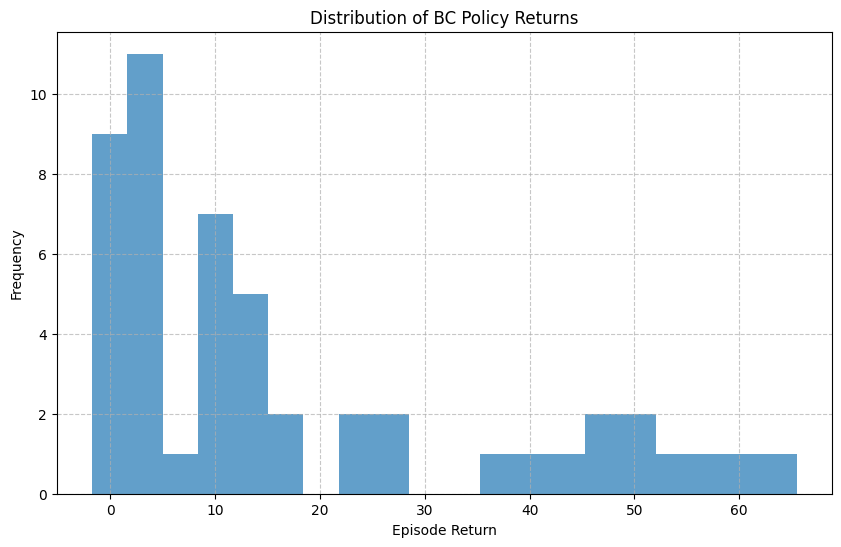

In [ ]:
"""
A class to wrap the BC model to make it more compatible with the evaluation framework
1. Takes a trained BC model and an action mapping dictionary
2. Has a select_action method that takes a state and returns an action index
"""
class BCPolicyWrapper:
    def __init__(self, model, action_map, device="cpu"):
        self.model = model.to(device)
        # Also create q_net reference for compatibility with CQL interface
        self.q_net = self.model  # Alias for compatibility
        self.inv_map = {v: k for k, v in action_map.items()}
        self.device = device

    def select_action(self, state):
        """Select best action according to BC policy"""
        # Convert state to tensor if it's not already
        if not isinstance(state, torch.Tensor):
            state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        else:
            # If already tensor, ensure it has batch dimension and is on correct device
            if state.dim() == 1:
                state = state.unsqueeze(0)
            state = state.to(self.device)
        # Return the action with the highest logit value (highest prob)
        with torch.no_grad():
            logits = self.model(state)
            action = logits.argmax(dim=1).item()
        return action

def main():
    # Load trained BC model
    input_dim = 64  # Based on your output
    model = BCModel(input_dim=input_dim, output_dim=50)
    model.load_state_dict(torch.load('best_bc_model.pt'))

    # Load data and preprocess it as before
    csv_file_path = "data.csv"
    train_states, val_states, train_actions, val_actions, num_actions = prepare_data_for_bc(csv_file_path)

    # Create datasets and loaders
    train_ds = TutorDataset(train_states, train_actions)
    val_ds = TutorDataset(val_states, val_actions)
    val_loader = DataLoader(val_ds, batch_size=128)

    # Use the predefined action mappings from system
    action_map = {0: 0, 1: 1, 2: 2, 3: 3, 5: 4, 6: 5, 7: 6, 8: 7, 11: 8, 12: 9,
              13: 10, 16: 11, 17: 12, 18: 13, 20: 14, 21: 15, 22: 16, 23: 17,
              26: 18, 27: 19, 28: 20, 31: 21, 32: 22, 36: 23, 37: 24, 38: 25,
              41: 26, 42: 27, 43: 28, 45: 29, 46: 30, 47: 31, 48: 32, 54: 33,
              55: 34, 56: 35, 57: 36, 58: 37, 59: 38, 60: 39, 65: 40, 66: 41,
              67: 42, 70: 43, 71: 44, 72: 45, 73: 46, 75: 47, 76: 48, 77: 49}

    # Define the action metadata map
    action_meta_map = {
        "Focus": {
            "Seek Next Step": {1: 0, 2: 1, 3: 2},
            "Confirm Calculation": {1: 5, 2: 6, 3: 7, 4: 8},
            "Re-direct to Sub-Problem": {2: 11, 3: 12, 4: 13},
            "Highlight Missing Info": {2: 16, 3: 17, 4: 18}
        },
        "Probing": {
            "Ask for Explanation": {1: 20, 2: 21, 3: 22, 4: 23},
            "Seek Self-Correction": {2: 26, 3: 27, 4: 28},
            "Hypothetical Variation": {2: 31, 3: 32},
            "Check Understanding/Concept": {2: 36, 3: 37, 4: 38},
            "Encourage Comparison": {2: 41, 3: 42, 4: 43}
        },
        "Telling": {
            "Partial Reveal (Strategy)": {1: 45, 2: 46, 3: 47, 4: 48},
            "Full Reveal (Answer)": {1: 54, 2: 55, 3: 56, 4: 57, 5: 58, 6: 59},
            "Corrective Explanation": {1: 60}
        },
        "Generic": {
            "Acknowledgment/Praise": {1: 65, 2: 66, 3: 67},
            "Summarize Progress": {1: 70, 2: 71, 3: 72, 4: 73},
            "General Inquiry/Filler": {1: 75, 2: 76, 3: 77}
        }
    }

    feature_names = [
        'misconception_type', 'convo_turn', 'previous_action_id',
        'listen_to_feedback', 'problem_progress', 'progress_delta',
        'correct_solution', 'next_action_hint_strength'
    ]


    # Run off-policy evaluation using the fixed function
    print("\nEvaluating BC policy performance:")

    # First build the transition buffer with all required parameters
    df = pd.read_csv(csv_file_path)

    buffer, action_mapping = build_transition_buffer(
        df=df,
        reward_fn=hybrid_reward,
        meta_map=action_meta_map,
        orig_to_idx=action_map,
        episode_column=None
    )

    # Create a BC policy wrapper for evaluation
    bc_agent = BCPolicyWrapper(model, action_map)

    # Evaluate the policy using the fixed function
    mean_return, episode_returns = evaluate_policy(
        agent=bc_agent,
        buffer=buffer,
        reward_fn=hybrid_reward,
        num_episodes=50,
        max_steps=80,
        action_meta_map=action_meta_map
    )

    # Print summary statistics about the buffer
    print("\nTransition Buffer Statistics:")
    print(f"Total transitions: {len(buffer)}")
    print(f"State dimension: {buffer.states.shape[1]}")
    print(f"Number of unique actions: {len(set(buffer.actions))}")


    print(f"Baseline BC policy return: {mean_return:.4f}")
    print(f"Episode return std: {np.std(episode_returns):.4f}")

    # Plot the distribution of returns
    plt.figure(figsize=(10, 6))
    plt.hist(episode_returns, bins=20, alpha=0.7)
    plt.xlabel('Episode Return')
    plt.ylabel('Frequency')
    plt.title('Distribution of BC Policy Returns')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.savefig('bc_returns_distribution.png')
    plt.show()
    plt.close()

if __name__ == "__main__":
    main()

In [ ]:
class QNetwork(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.net(x)
"""
Why CQL?
It's offline and good to ensure a conservatively learned policy - don't overestimate out of distribution action rewards.

Vanilla QL overestimates values for unseen (s,a) pairs, and so CQL adds a regularization term that penalizes Q values for actions not seen in the dataset to make the policy more conservative. This is important in educaitonal settings that can affect student learning outcomes. Also, we don't have a good simulator to interact with the environment.
"""
class CQLAgent:
    def __init__(
        self,
        state_dim,
        action_dim,
        hidden_dim=256,
        lr=3e-4,
        gamma=0.99,
        tau=0.005,
        cql_alpha=1.0,
        device="cuda" if torch.cuda.is_available() else "cpu"
    ):
        self.action_dim = action_dim
        self.gamma = gamma
        self.tau = tau
        self.cql_alpha = cql_alpha
        self.device = device

        # 2 Q-networks, target network used for stable learning
        self.q_net = QNetwork(state_dim, action_dim, hidden_dim).to(device)
        self.target_q_net = QNetwork(state_dim, action_dim, hidden_dim).to(device)
        self.target_q_net.load_state_dict(self.q_net.state_dict())

        # Freeze target network (prevent moving target problem)
        for param in self.target_q_net.parameters():
            param.requires_grad = False

        self.optimizer = optim.Adam(self.q_net.parameters(), lr=lr)

        self.training_stats = {
            'q_loss': [],
            'cql_loss': [],
            'total_loss': [],
            'avg_q_values': []
        }

    def select_action(self, state):
        # Select the best action according to the Q-network
        with torch.no_grad():
            state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
            q_values = self.q_net(state)
            action = q_values.argmax(dim=1).item()
        return action
    # MOST IMPORTANT!
    def update(self, batch):
        # update the Q network using CQL loss
        states, actions, rewards, next_states, dones = batch
        states = states.to(self.device)
        actions = actions.to(self.device)
        rewards = rewards.to(self.device)
        next_states = next_states.to(self.device)
        dones = dones.to(self.device)

        batch_size = states.shape[0]

        # Compute Q values and target Q values
        q_values = self.q_net(states)
        with torch.no_grad():
            next_q_values = self.target_q_net(next_states)
            next_actions = next_q_values.argmax(dim=1)
            next_q = next_q_values.gather(1, next_actions.unsqueeze(1)).squeeze()
            target_q = rewards + (1 - dones) * self.gamma * next_q

        # TD error for the sampled actions (like vanilla Q learning)
        # Standard Bellman error
        q_values_sampled = q_values.gather(1, actions.unsqueeze(1)).squeeze() # selects the Q values corresponding to the specific action indices that were chosen in the offline dataset (the action demonstrated by the expert at that state)
        td_loss = F.mse_loss(q_values_sampled, target_q)

        # CQL loss: Minimize Q values for actions not in the dataset
        # This implementation follows the simplified CQL version
        logsumexp_q = torch.logsumexp(q_values, dim=1)
        """
        logSumExp(x₁, x₂, ..., xₙ) = log(exp(x₁) + exp(x₂) + ... + exp(xₙ))
        A smooth approximation of the maximum function across the action dimension. When one value is significantly larger than the others, it dominates the sum inside the log (and is differentiable)
        """


        # logsumexp_q is the 'soft' maximum Q value across all actions for each state
        # q_values_sampled is the Q value for the actions in the dataset (actions demonstrated by the expert)
        cql_loss = (logsumexp_q - q_values_sampled).mean()
        """
        When the difference between the max  over all action values for each state and the q val of demonstrated actions is LARGE, it means the model is overestimating Q values for actions not in the dataset.
        Th CQL objective is to MINIMIZE this difference by penalizing the model for overestimation.

        This pushes Q values down for all non-dataset actions while preserving the values for actions the expert tutors actually took.
        """
        # Total loss
        loss = td_loss + self.cql_alpha * cql_loss # add cql regularization term

        # Optimize
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update target network, periodic updates (low tau, low updates) for stable learning
        for param, target_param in zip(self.q_net.parameters(), self.target_q_net.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

        # Record statistics
        self.training_stats['q_loss'].append(td_loss.item())
        self.training_stats['cql_loss'].append(cql_loss.item())
        self.training_stats['total_loss'].append(loss.item())
        self.training_stats['avg_q_values'].append(q_values.mean().item())

        return td_loss.item(), cql_loss.item(), loss.item()

    def save(self, path):
        """Save the Q-network model"""
        torch.save({
            'q_net': self.q_net.state_dict(),
            'target_q_net': self.target_q_net.state_dict(),
            'optimizer': self.optimizer.state_dict(),
            'training_stats': self.training_stats
        }, path)

    def load(self, path):
        """Load the Q-network model"""
        checkpoint = torch.load(path)
        self.q_net.load_state_dict(checkpoint['q_net'])
        self.target_q_net.load_state_dict(checkpoint['target_q_net'])
        self.optimizer.load_state_dict(checkpoint['optimizer'])
        self.training_stats = checkpoint['training_stats']

    def plot_training_curves(self):
        """Plot the training curves"""
        fig, axs = plt.subplots(2, 2, figsize=(15, 10))

        # Plot Q loss
        axs[0, 0].plot(self.training_stats['q_loss'])
        axs[0, 0].set_title('TD Loss')
        axs[0, 0].set_xlabel('Updates')
        axs[0, 0].set_ylabel('Loss')

        # Plot CQL loss
        axs[0, 1].plot(self.training_stats['cql_loss'])
        axs[0, 1].set_title('CQL Loss')
        axs[0, 1].set_xlabel('Updates')
        axs[0, 1].set_ylabel('Loss')

        # Plot total loss
        axs[1, 0].plot(self.training_stats['total_loss'])
        axs[1, 0].set_title('Total Loss')
        axs[1, 0].set_xlabel('Updates')
        axs[1, 0].set_ylabel('Loss')

        # Plot average Q values
        axs[1, 1].plot(self.training_stats['avg_q_values'])
        axs[1, 1].set_title('Average Q Values')
        axs[1, 1].set_xlabel('Updates')
        axs[1, 1].set_ylabel('Q Value')

        plt.tight_layout()
        plt.savefig('cql_training_curves.png')
        plt.close()

def prepare_buffer_for_training(buffer, batch_size=128, action_map=None):
    """Convert the transition buffer to PyTorch tensors for training"""
    states = torch.FloatTensor(np.array(buffer.states))

    # Map original action IDs -> model indices
    if action_map:
        mapped_actions = [action_map.get(a, 0) for a in buffer.actions]
        actions = torch.LongTensor(mapped_actions)
    else:
        actions = torch.LongTensor(buffer.actions)

    rewards = torch.FloatTensor(np.array(buffer.rewards))
    next_states = torch.FloatTensor(np.array(buffer.next_states))
    dones = torch.FloatTensor(np.array(buffer.dones))

    dataset = TensorDataset(states, actions, rewards, next_states, dones)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)


"""
Train a CQL agent on the given transition buffer
1. Prepare data from the transition buffer
2. Initialize the CQL agent
3. Train over multiple epochs
4. Periodically evaluate performance
4. Save the best model
"""
def train_cql(buffer, state_dim, action_dim, num_epochs=100, batch_size=128,
              hidden_dim=256, lr=3e-4, gamma=0.99, tau=0.005, cql_alpha=1.0,
              eval_interval=5, model_save_path='cql_agent.pt', action_map=None, action_meta_map=None):
    # Prepare data
    dataloader = prepare_buffer_for_training(buffer, batch_size, action_map)

    # Initialize agent
    agent = CQLAgent(
        state_dim=state_dim,
        action_dim=action_dim,
        hidden_dim=hidden_dim,
        lr=lr,
        gamma=gamma,
        tau=tau,
        cql_alpha=cql_alpha
    )

    print(f"Training CQL agent with {len(buffer)} transitions")
    print(f"State dim: {state_dim}, Action dim: {action_dim}")
    print(f"CQL alpha: {cql_alpha}, Learning rate: {lr}")

    # Training loop
    best_eval_return = -float('inf')

    for epoch in range(num_epochs):
        epoch_td_loss = 0
        epoch_cql_loss = 0
        epoch_total_loss = 0
        num_batches = 0

        # Training
        agent.q_net.train()
        progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")

        for batch in progress_bar:
            td_loss, cql_loss, total_loss = agent.update(batch)
            epoch_td_loss += td_loss
            epoch_cql_loss += cql_loss
            epoch_total_loss += total_loss
            num_batches += 1

            progress_bar.set_postfix({
                'td_loss': td_loss,
                'cql_loss': cql_loss,
                'total_loss': total_loss
            })

        # Calculate average losses
        epoch_td_loss /= num_batches
        epoch_cql_loss /= num_batches
        epoch_total_loss /= num_batches

        print(f"\nEpoch {epoch+1}/{num_epochs} - TD Loss: {epoch_td_loss:.4f}, "
              f"CQL Loss: {epoch_cql_loss:.4f}, Total Loss: {epoch_total_loss:.4f}")

        # Evaluation
        if (epoch + 1) % eval_interval == 0:
            # Evaluate the policy using the fixed function
            mean_return, _ = evaluate_policy(
                agent=agent,
                buffer=buffer,
                reward_fn=hybrid_reward,
                num_episodes=20,
                max_steps=80,
                action_meta_map=action_meta_map
            )
            print(f"Evaluation - Mean Return: {mean_return:.4f}")

            # Save best model
            if mean_return > best_eval_return:
                best_eval_return = mean_return
                agent.save(model_save_path)
                print(f"New best model saved with return: {best_eval_return:.4f}")

    # Plot training curves
    agent.plot_training_curves()

    # Load the best model for final evaluation
    agent.load(model_save_path)
    # Unpack the tuple here too
    final_mean_return, final_returns = evaluate_policy(
        agent=agent,
        buffer=buffer,
        reward_fn=hybrid_reward,
        num_episodes=50,
        max_steps=60
    )
    print(f"\nFinal Evaluation - Mean Return: {final_mean_return:.4f}")

    return agent


"""
Initialize a CQL agent using weights from a pre-trained BC model
Motivation: to give CQL a good starting point, since BC has already learning meaningful state representations (warm start)
"""
def convert_bc_to_cql_model(bc_model, action_dim):
    # Get the input dimension from the BC model
    input_dim = bc_model.net[0].in_features

    # Create a CQL agent with the same dimensions
    cql_agent = CQLAgent(state_dim=input_dim, action_dim=action_dim)

    # Copy the feature extractor weights (first two layers)
    cql_agent.q_net.net[0].weight.data.copy_(bc_model.net[0].weight.data)
    cql_agent.q_net.net[0].bias.data.copy_(bc_model.net[0].bias.data)
    cql_agent.q_net.net[2].weight.data.copy_(bc_model.net[2].weight.data)
    cql_agent.q_net.net[2].bias.data.copy_(bc_model.net[2].bias.data)

    # Initialize the Q-value layer
    # The output dimension will be different, so can't copy directly

    # Copy to target network
    cql_agent.target_q_net.load_state_dict(cql_agent.q_net.state_dict())

    return cql_agent


Transition Buffer Statistics:
Total transitions: 12017
State dimension: 64
Number of unique actions: 50
Could not load models. Training from scratch...

Training CQL from scratch...
Training CQL agent with 12017 transitions
State dim: 64, Action dim: 50
CQL alpha: 2.0, Learning rate: 0.0001


Epoch 1/100: 100%|██████████| 47/47 [00:01<00:00, 28.77it/s, td_loss=5.16, cql_loss=2.67, total_loss=10.5]



Epoch 1/100 - TD Loss: 5.9775, CQL Loss: 2.8905, Total Loss: 11.7584


Epoch 2/100: 100%|██████████| 47/47 [00:01<00:00, 28.82it/s, td_loss=5.12, cql_loss=2.66, total_loss=10.4]



Epoch 2/100 - TD Loss: 5.0922, CQL Loss: 2.5838, Total Loss: 10.2598


Epoch 3/100: 100%|██████████| 47/47 [00:01<00:00, 44.72it/s, td_loss=4.31, cql_loss=2.54, total_loss=9.4]



Epoch 3/100 - TD Loss: 4.9637, CQL Loss: 2.5082, Total Loss: 9.9801


Epoch 4/100: 100%|██████████| 47/47 [00:01<00:00, 46.47it/s, td_loss=4.95, cql_loss=2.27, total_loss=9.49]



Epoch 4/100 - TD Loss: 4.9243, CQL Loss: 2.4361, Total Loss: 9.7966


Epoch 5/100: 100%|██████████| 47/47 [00:01<00:00, 42.28it/s, td_loss=5.31, cql_loss=2.46, total_loss=10.2]



Epoch 5/100 - TD Loss: 4.9060, CQL Loss: 2.3824, Total Loss: 9.6709

Evaluation over 20 episodes:
  Mean return: 12.8046 ± 20.3723
  Mean episode length: 14.50
  Termination reasons: {'max_steps': 2, 'done': 18, 'buffer_end': 0}
Evaluation - Mean Return: 12.8046
New best model saved with return: 12.8046


Epoch 6/100: 100%|██████████| 47/47 [00:01<00:00, 40.08it/s, td_loss=4.68, cql_loss=2.29, total_loss=9.26]



Epoch 6/100 - TD Loss: 4.9049, CQL Loss: 2.3283, Total Loss: 9.5616


Epoch 7/100: 100%|██████████| 47/47 [00:01<00:00, 40.38it/s, td_loss=4.78, cql_loss=2.2, total_loss=9.17]



Epoch 7/100 - TD Loss: 4.9026, CQL Loss: 2.2731, Total Loss: 9.4487


Epoch 8/100: 100%|██████████| 47/47 [00:00<00:00, 56.93it/s, td_loss=5.53, cql_loss=2.23, total_loss=9.99]



Epoch 8/100 - TD Loss: 4.8932, CQL Loss: 2.2324, Total Loss: 9.3581


Epoch 9/100: 100%|██████████| 47/47 [00:00<00:00, 57.49it/s, td_loss=5.08, cql_loss=2.16, total_loss=9.4]



Epoch 9/100 - TD Loss: 4.8629, CQL Loss: 2.1881, Total Loss: 9.2391


Epoch 10/100: 100%|██████████| 47/47 [00:01<00:00, 43.76it/s, td_loss=5.06, cql_loss=2.17, total_loss=9.39]



Epoch 10/100 - TD Loss: 4.8170, CQL Loss: 2.1523, Total Loss: 9.1215

Evaluation over 20 episodes:
  Mean return: 19.2200 ± 22.2016
  Mean episode length: 22.80
  Termination reasons: {'max_steps': 3, 'done': 17, 'buffer_end': 0}
Evaluation - Mean Return: 19.2200
New best model saved with return: 19.2200


Epoch 11/100: 100%|██████████| 47/47 [00:00<00:00, 58.28it/s, td_loss=4.17, cql_loss=2.14, total_loss=8.45]



Epoch 11/100 - TD Loss: 4.7070, CQL Loss: 2.1288, Total Loss: 8.9646


Epoch 12/100: 100%|██████████| 47/47 [00:00<00:00, 54.42it/s, td_loss=5.11, cql_loss=2.04, total_loss=9.19]



Epoch 12/100 - TD Loss: 4.6280, CQL Loss: 2.0999, Total Loss: 8.8277


Epoch 13/100: 100%|██████████| 47/47 [00:01<00:00, 43.06it/s, td_loss=4.08, cql_loss=2.07, total_loss=8.22]



Epoch 13/100 - TD Loss: 4.5013, CQL Loss: 2.0834, Total Loss: 8.6681


Epoch 14/100: 100%|██████████| 47/47 [00:01<00:00, 42.16it/s, td_loss=4.34, cql_loss=2.14, total_loss=8.63]



Epoch 14/100 - TD Loss: 4.4230, CQL Loss: 2.0686, Total Loss: 8.5602


Epoch 15/100: 100%|██████████| 47/47 [00:01<00:00, 39.33it/s, td_loss=4.24, cql_loss=2.19, total_loss=8.62]



Epoch 15/100 - TD Loss: 4.3011, CQL Loss: 2.0483, Total Loss: 8.3977

Evaluation over 20 episodes:
  Mean return: 14.7819 ± 17.1518
  Mean episode length: 19.70
  Termination reasons: {'max_steps': 3, 'done': 17, 'buffer_end': 0}
Evaluation - Mean Return: 14.7819


Epoch 16/100: 100%|██████████| 47/47 [00:00<00:00, 54.70it/s, td_loss=4.53, cql_loss=2.02, total_loss=8.56]



Epoch 16/100 - TD Loss: 4.1782, CQL Loss: 2.0522, Total Loss: 8.2825


Epoch 17/100: 100%|██████████| 47/47 [00:00<00:00, 54.48it/s, td_loss=4.14, cql_loss=1.93, total_loss=8.01]



Epoch 17/100 - TD Loss: 4.1257, CQL Loss: 2.0300, Total Loss: 8.1858


Epoch 18/100: 100%|██████████| 47/47 [00:00<00:00, 55.22it/s, td_loss=3.16, cql_loss=1.95, total_loss=7.05]



Epoch 18/100 - TD Loss: 4.0797, CQL Loss: 2.0280, Total Loss: 8.1358


Epoch 19/100: 100%|██████████| 47/47 [00:00<00:00, 55.35it/s, td_loss=5.03, cql_loss=2.14, total_loss=9.3]



Epoch 19/100 - TD Loss: 4.0682, CQL Loss: 2.0174, Total Loss: 8.1030


Epoch 20/100: 100%|██████████| 47/47 [00:00<00:00, 55.85it/s, td_loss=5.03, cql_loss=2.12, total_loss=9.27]



Epoch 20/100 - TD Loss: 4.1137, CQL Loss: 2.0114, Total Loss: 8.1366

Evaluation over 20 episodes:
  Mean return: 16.4163 ± 20.5072
  Mean episode length: 21.25
  Termination reasons: {'max_steps': 3, 'done': 17, 'buffer_end': 0}
Evaluation - Mean Return: 16.4163


Epoch 21/100: 100%|██████████| 47/47 [00:00<00:00, 56.46it/s, td_loss=3.57, cql_loss=2.04, total_loss=7.64]



Epoch 21/100 - TD Loss: 4.1880, CQL Loss: 2.0007, Total Loss: 8.1894


Epoch 22/100: 100%|██████████| 47/47 [00:00<00:00, 55.02it/s, td_loss=5.12, cql_loss=2.09, total_loss=9.3]



Epoch 22/100 - TD Loss: 4.3009, CQL Loss: 1.9949, Total Loss: 8.2907


Epoch 23/100: 100%|██████████| 47/47 [00:00<00:00, 53.62it/s, td_loss=3.82, cql_loss=1.9, total_loss=7.61]



Epoch 23/100 - TD Loss: 4.4302, CQL Loss: 1.9881, Total Loss: 8.4064


Epoch 24/100: 100%|██████████| 47/47 [00:00<00:00, 52.56it/s, td_loss=4.83, cql_loss=2.15, total_loss=9.12]



Epoch 24/100 - TD Loss: 4.6019, CQL Loss: 1.9798, Total Loss: 8.5615


Epoch 25/100: 100%|██████████| 47/47 [00:00<00:00, 52.86it/s, td_loss=5.43, cql_loss=2.02, total_loss=9.47]



Epoch 25/100 - TD Loss: 4.8018, CQL Loss: 1.9721, Total Loss: 8.7460

Evaluation over 20 episodes:
  Mean return: 20.2854 ± 21.9320
  Mean episode length: 24.75
  Termination reasons: {'max_steps': 4, 'done': 16, 'buffer_end': 0}
Evaluation - Mean Return: 20.2854
New best model saved with return: 20.2854


Epoch 26/100: 100%|██████████| 47/47 [00:00<00:00, 54.01it/s, td_loss=4.66, cql_loss=1.97, total_loss=8.59]



Epoch 26/100 - TD Loss: 4.9824, CQL Loss: 1.9654, Total Loss: 8.9131


Epoch 27/100: 100%|██████████| 47/47 [00:01<00:00, 33.18it/s, td_loss=5.21, cql_loss=1.93, total_loss=9.07]



Epoch 27/100 - TD Loss: 5.1939, CQL Loss: 1.9591, Total Loss: 9.1122


Epoch 28/100: 100%|██████████| 47/47 [00:01<00:00, 40.65it/s, td_loss=5.86, cql_loss=1.97, total_loss=9.79]



Epoch 28/100 - TD Loss: 5.4473, CQL Loss: 1.9593, Total Loss: 9.3659


Epoch 29/100: 100%|██████████| 47/47 [00:01<00:00, 42.56it/s, td_loss=5.35, cql_loss=2, total_loss=9.34]



Epoch 29/100 - TD Loss: 5.6338, CQL Loss: 1.9438, Total Loss: 9.5215


Epoch 30/100: 100%|██████████| 47/47 [00:00<00:00, 52.86it/s, td_loss=6, cql_loss=1.97, total_loss=9.93]



Epoch 30/100 - TD Loss: 5.8275, CQL Loss: 1.9409, Total Loss: 9.7093

Evaluation over 20 episodes:
  Mean return: 11.3437 ± 17.0109
  Mean episode length: 15.15
  Termination reasons: {'max_steps': 2, 'done': 18, 'buffer_end': 0}
Evaluation - Mean Return: 11.3437


Epoch 31/100: 100%|██████████| 47/47 [00:00<00:00, 54.70it/s, td_loss=6.79, cql_loss=1.94, total_loss=10.7]



Epoch 31/100 - TD Loss: 6.0696, CQL Loss: 1.9342, Total Loss: 9.9380


Epoch 32/100: 100%|██████████| 47/47 [00:00<00:00, 54.07it/s, td_loss=5.2, cql_loss=1.96, total_loss=9.13]



Epoch 32/100 - TD Loss: 6.2476, CQL Loss: 1.9392, Total Loss: 10.1260


Epoch 33/100: 100%|██████████| 47/47 [00:00<00:00, 54.35it/s, td_loss=7.79, cql_loss=2.03, total_loss=11.8]



Epoch 33/100 - TD Loss: 6.4750, CQL Loss: 1.9163, Total Loss: 10.3075


Epoch 34/100: 100%|██████████| 47/47 [00:00<00:00, 55.42it/s, td_loss=6.78, cql_loss=2.07, total_loss=10.9]



Epoch 34/100 - TD Loss: 6.6421, CQL Loss: 1.9190, Total Loss: 10.4801


Epoch 35/100: 100%|██████████| 47/47 [00:00<00:00, 53.27it/s, td_loss=5.57, cql_loss=1.77, total_loss=9.11]



Epoch 35/100 - TD Loss: 6.8390, CQL Loss: 1.9074, Total Loss: 10.6538

Evaluation over 20 episodes:
  Mean return: 12.0847 ± 12.9896
  Mean episode length: 16.10
  Termination reasons: {'max_steps': 2, 'done': 18, 'buffer_end': 0}
Evaluation - Mean Return: 12.0847


Epoch 36/100: 100%|██████████| 47/47 [00:01<00:00, 43.35it/s, td_loss=7.52, cql_loss=1.88, total_loss=11.3]



Epoch 36/100 - TD Loss: 7.0389, CQL Loss: 1.9170, Total Loss: 10.8728


Epoch 37/100: 100%|██████████| 47/47 [00:00<00:00, 47.70it/s, td_loss=6.69, cql_loss=1.82, total_loss=10.3]



Epoch 37/100 - TD Loss: 7.1624, CQL Loss: 1.9061, Total Loss: 10.9745


Epoch 38/100: 100%|██████████| 47/47 [00:00<00:00, 47.14it/s, td_loss=7.31, cql_loss=1.89, total_loss=11.1]



Epoch 38/100 - TD Loss: 7.3624, CQL Loss: 1.9040, Total Loss: 11.1703


Epoch 39/100: 100%|██████████| 47/47 [00:00<00:00, 55.48it/s, td_loss=7.71, cql_loss=1.85, total_loss=11.4]



Epoch 39/100 - TD Loss: 7.5456, CQL Loss: 1.8932, Total Loss: 11.3320


Epoch 40/100: 100%|██████████| 47/47 [00:01<00:00, 45.20it/s, td_loss=7.26, cql_loss=1.9, total_loss=11.1]



Epoch 40/100 - TD Loss: 7.6417, CQL Loss: 1.8907, Total Loss: 11.4232

Evaluation over 20 episodes:
  Mean return: 16.8560 ± 20.0034
  Mean episode length: 22.20
  Termination reasons: {'max_steps': 3, 'done': 17, 'buffer_end': 0}
Evaluation - Mean Return: 16.8560


Epoch 41/100: 100%|██████████| 47/47 [00:01<00:00, 42.90it/s, td_loss=7.7, cql_loss=1.95, total_loss=11.6]



Epoch 41/100 - TD Loss: 7.7893, CQL Loss: 1.8918, Total Loss: 11.5730


Epoch 42/100: 100%|██████████| 47/47 [00:01<00:00, 38.34it/s, td_loss=8.59, cql_loss=1.91, total_loss=12.4]



Epoch 42/100 - TD Loss: 7.9340, CQL Loss: 1.8818, Total Loss: 11.6976


Epoch 43/100: 100%|██████████| 47/47 [00:00<00:00, 53.85it/s, td_loss=6.54, cql_loss=1.89, total_loss=10.3]



Epoch 43/100 - TD Loss: 8.0299, CQL Loss: 1.8869, Total Loss: 11.8036


Epoch 44/100: 100%|██████████| 47/47 [00:00<00:00, 54.46it/s, td_loss=7.61, cql_loss=1.91, total_loss=11.4]



Epoch 44/100 - TD Loss: 8.1197, CQL Loss: 1.8790, Total Loss: 11.8778


Epoch 45/100: 100%|██████████| 47/47 [00:00<00:00, 55.06it/s, td_loss=9.11, cql_loss=1.94, total_loss=13]



Epoch 45/100 - TD Loss: 8.1912, CQL Loss: 1.8746, Total Loss: 11.9404

Evaluation over 20 episodes:
  Mean return: 16.7628 ± 17.7668
  Mean episode length: 26.90
  Termination reasons: {'max_steps': 4, 'done': 16, 'buffer_end': 0}
Evaluation - Mean Return: 16.7628


Epoch 46/100: 100%|██████████| 47/47 [00:00<00:00, 55.67it/s, td_loss=9.26, cql_loss=1.83, total_loss=12.9]



Epoch 46/100 - TD Loss: 8.2656, CQL Loss: 1.8817, Total Loss: 12.0290


Epoch 47/100: 100%|██████████| 47/47 [00:00<00:00, 56.22it/s, td_loss=8.28, cql_loss=1.93, total_loss=12.1]



Epoch 47/100 - TD Loss: 8.4076, CQL Loss: 1.8646, Total Loss: 12.1367


Epoch 48/100: 100%|██████████| 47/47 [00:00<00:00, 54.33it/s, td_loss=7.67, cql_loss=1.95, total_loss=11.6]



Epoch 48/100 - TD Loss: 8.4863, CQL Loss: 1.8597, Total Loss: 12.2057


Epoch 49/100: 100%|██████████| 47/47 [00:00<00:00, 54.46it/s, td_loss=7.1, cql_loss=1.81, total_loss=10.7]



Epoch 49/100 - TD Loss: 8.5855, CQL Loss: 1.8812, Total Loss: 12.3480


Epoch 50/100: 100%|██████████| 47/47 [00:00<00:00, 54.30it/s, td_loss=8.89, cql_loss=1.83, total_loss=12.5]



Epoch 50/100 - TD Loss: 8.7832, CQL Loss: 1.8627, Total Loss: 12.5087

Evaluation over 20 episodes:
  Mean return: 17.9216 ± 21.3662
  Mean episode length: 27.60
  Termination reasons: {'max_steps': 5, 'done': 15, 'buffer_end': 0}
Evaluation - Mean Return: 17.9216


Epoch 51/100: 100%|██████████| 47/47 [00:00<00:00, 54.46it/s, td_loss=8.44, cql_loss=1.95, total_loss=12.3]



Epoch 51/100 - TD Loss: 8.8453, CQL Loss: 1.8523, Total Loss: 12.5499


Epoch 52/100: 100%|██████████| 47/47 [00:00<00:00, 54.94it/s, td_loss=9.82, cql_loss=1.89, total_loss=13.6]



Epoch 52/100 - TD Loss: 8.9742, CQL Loss: 1.8545, Total Loss: 12.6832


Epoch 53/100: 100%|██████████| 47/47 [00:01<00:00, 44.79it/s, td_loss=9.21, cql_loss=1.84, total_loss=12.9]



Epoch 53/100 - TD Loss: 9.0781, CQL Loss: 1.8535, Total Loss: 12.7850


Epoch 54/100: 100%|██████████| 47/47 [00:01<00:00, 42.97it/s, td_loss=8.86, cql_loss=1.82, total_loss=12.5]



Epoch 54/100 - TD Loss: 9.1915, CQL Loss: 1.8549, Total Loss: 12.9013


Epoch 55/100: 100%|██████████| 47/47 [00:01<00:00, 40.77it/s, td_loss=10.5, cql_loss=1.86, total_loss=14.2]



Epoch 55/100 - TD Loss: 9.3260, CQL Loss: 1.8541, Total Loss: 13.0342

Evaluation over 20 episodes:
  Mean return: 13.0011 ± 17.9648
  Mean episode length: 17.30
  Termination reasons: {'max_steps': 3, 'done': 17, 'buffer_end': 0}
Evaluation - Mean Return: 13.0011


Epoch 56/100: 100%|██████████| 47/47 [00:01<00:00, 39.41it/s, td_loss=10.8, cql_loss=1.78, total_loss=14.4]



Epoch 56/100 - TD Loss: 9.4850, CQL Loss: 1.8470, Total Loss: 13.1791


Epoch 57/100: 100%|██████████| 47/47 [00:00<00:00, 54.02it/s, td_loss=8.64, cql_loss=1.98, total_loss=12.6]



Epoch 57/100 - TD Loss: 9.5042, CQL Loss: 1.8542, Total Loss: 13.2125


Epoch 58/100: 100%|██████████| 47/47 [00:00<00:00, 52.93it/s, td_loss=9.3, cql_loss=1.77, total_loss=12.8]



Epoch 58/100 - TD Loss: 9.5982, CQL Loss: 1.8364, Total Loss: 13.2711


Epoch 59/100: 100%|██████████| 47/47 [00:00<00:00, 54.11it/s, td_loss=10.8, cql_loss=1.8, total_loss=14.4]



Epoch 59/100 - TD Loss: 9.6818, CQL Loss: 1.8455, Total Loss: 13.3729


Epoch 60/100: 100%|██████████| 47/47 [00:00<00:00, 55.52it/s, td_loss=9.05, cql_loss=1.86, total_loss=12.8]



Epoch 60/100 - TD Loss: 9.8072, CQL Loss: 1.8406, Total Loss: 13.4885

Evaluation over 20 episodes:
  Mean return: 16.3719 ± 19.3236
  Mean episode length: 22.95
  Termination reasons: {'max_steps': 4, 'done': 16, 'buffer_end': 0}
Evaluation - Mean Return: 16.3719


Epoch 61/100: 100%|██████████| 47/47 [00:00<00:00, 53.35it/s, td_loss=11.4, cql_loss=1.76, total_loss=14.9]



Epoch 61/100 - TD Loss: 9.9051, CQL Loss: 1.8376, Total Loss: 13.5804


Epoch 62/100: 100%|██████████| 47/47 [00:01<00:00, 44.58it/s, td_loss=8.2, cql_loss=1.91, total_loss=12]



Epoch 62/100 - TD Loss: 9.9638, CQL Loss: 1.8409, Total Loss: 13.6457


Epoch 63/100: 100%|██████████| 47/47 [00:00<00:00, 54.41it/s, td_loss=9.05, cql_loss=1.89, total_loss=12.8]



Epoch 63/100 - TD Loss: 10.0570, CQL Loss: 1.8339, Total Loss: 13.7248


Epoch 64/100: 100%|██████████| 47/47 [00:00<00:00, 54.80it/s, td_loss=9.51, cql_loss=1.7, total_loss=12.9]



Epoch 64/100 - TD Loss: 10.1487, CQL Loss: 1.8300, Total Loss: 13.8088


Epoch 65/100: 100%|██████████| 47/47 [00:00<00:00, 54.07it/s, td_loss=9.12, cql_loss=1.96, total_loss=13]



Epoch 65/100 - TD Loss: 10.2062, CQL Loss: 1.8300, Total Loss: 13.8663

Evaluation over 20 episodes:
  Mean return: 15.5331 ± 19.0994
  Mean episode length: 23.10
  Termination reasons: {'max_steps': 3, 'done': 17, 'buffer_end': 0}
Evaluation - Mean Return: 15.5331


Epoch 66/100: 100%|██████████| 47/47 [00:00<00:00, 53.92it/s, td_loss=8.74, cql_loss=1.77, total_loss=12.3]



Epoch 66/100 - TD Loss: 10.3080, CQL Loss: 1.8230, Total Loss: 13.9540


Epoch 67/100: 100%|██████████| 47/47 [00:00<00:00, 50.51it/s, td_loss=13.7, cql_loss=1.9, total_loss=17.5]



Epoch 67/100 - TD Loss: 10.4351, CQL Loss: 1.8299, Total Loss: 14.0949


Epoch 68/100: 100%|██████████| 47/47 [00:01<00:00, 38.22it/s, td_loss=11.5, cql_loss=1.76, total_loss=15]



Epoch 68/100 - TD Loss: 10.4645, CQL Loss: 1.8256, Total Loss: 14.1157


Epoch 69/100: 100%|██████████| 47/47 [00:01<00:00, 37.47it/s, td_loss=12.4, cql_loss=1.87, total_loss=16.2]



Epoch 69/100 - TD Loss: 10.5462, CQL Loss: 1.8200, Total Loss: 14.1862


Epoch 70/100: 100%|██████████| 47/47 [00:01<00:00, 45.29it/s, td_loss=8.3, cql_loss=1.85, total_loss=12]



Epoch 70/100 - TD Loss: 10.6692, CQL Loss: 1.8176, Total Loss: 14.3044

Evaluation over 20 episodes:
  Mean return: 11.0670 ± 10.6503
  Mean episode length: 15.70
  Termination reasons: {'max_steps': 1, 'done': 19, 'buffer_end': 0}
Evaluation - Mean Return: 11.0670


Epoch 71/100: 100%|██████████| 47/47 [00:00<00:00, 55.04it/s, td_loss=11, cql_loss=1.76, total_loss=14.5]



Epoch 71/100 - TD Loss: 10.6587, CQL Loss: 1.8262, Total Loss: 14.3111


Epoch 72/100: 100%|██████████| 47/47 [00:00<00:00, 55.08it/s, td_loss=13.1, cql_loss=1.82, total_loss=16.7]



Epoch 72/100 - TD Loss: 10.7772, CQL Loss: 1.8092, Total Loss: 14.3956


Epoch 73/100: 100%|██████████| 47/47 [00:00<00:00, 55.40it/s, td_loss=12.6, cql_loss=1.9, total_loss=16.4]



Epoch 73/100 - TD Loss: 10.8486, CQL Loss: 1.8210, Total Loss: 14.4906


Epoch 74/100: 100%|██████████| 47/47 [00:00<00:00, 53.51it/s, td_loss=10.2, cql_loss=1.71, total_loss=13.7]



Epoch 74/100 - TD Loss: 10.8938, CQL Loss: 1.8096, Total Loss: 14.5131


Epoch 75/100: 100%|██████████| 47/47 [00:00<00:00, 54.22it/s, td_loss=10.5, cql_loss=1.66, total_loss=13.8]



Epoch 75/100 - TD Loss: 10.9753, CQL Loss: 1.8158, Total Loss: 14.6068

Evaluation over 20 episodes:
  Mean return: 16.2690 ± 18.9052
  Mean episode length: 24.70
  Termination reasons: {'max_steps': 4, 'done': 16, 'buffer_end': 0}
Evaluation - Mean Return: 16.2690


Epoch 76/100: 100%|██████████| 47/47 [00:00<00:00, 53.90it/s, td_loss=9.7, cql_loss=1.79, total_loss=13.3]



Epoch 76/100 - TD Loss: 11.0423, CQL Loss: 1.8091, Total Loss: 14.6606


Epoch 77/100: 100%|██████████| 47/47 [00:00<00:00, 54.69it/s, td_loss=9.71, cql_loss=1.82, total_loss=13.4]



Epoch 77/100 - TD Loss: 11.1225, CQL Loss: 1.8076, Total Loss: 14.7376


Epoch 78/100: 100%|██████████| 47/47 [00:00<00:00, 52.99it/s, td_loss=10.9, cql_loss=1.9, total_loss=14.7]



Epoch 78/100 - TD Loss: 11.1494, CQL Loss: 1.8106, Total Loss: 14.7707


Epoch 79/100: 100%|██████████| 47/47 [00:01<00:00, 42.99it/s, td_loss=12.8, cql_loss=1.76, total_loss=16.3]



Epoch 79/100 - TD Loss: 11.2357, CQL Loss: 1.8086, Total Loss: 14.8528


Epoch 80/100: 100%|██████████| 47/47 [00:00<00:00, 54.64it/s, td_loss=8.9, cql_loss=1.8, total_loss=12.5]



Epoch 80/100 - TD Loss: 11.3162, CQL Loss: 1.8054, Total Loss: 14.9270

Evaluation over 20 episodes:
  Mean return: 20.2863 ± 25.8903
  Mean episode length: 25.10
  Termination reasons: {'max_steps': 5, 'done': 15, 'buffer_end': 0}
Evaluation - Mean Return: 20.2863
New best model saved with return: 20.2863


Epoch 81/100: 100%|██████████| 47/47 [00:01<00:00, 42.25it/s, td_loss=14.1, cql_loss=1.88, total_loss=17.8]



Epoch 81/100 - TD Loss: 11.3599, CQL Loss: 1.7930, Total Loss: 14.9458


Epoch 82/100: 100%|██████████| 47/47 [00:01<00:00, 40.16it/s, td_loss=14, cql_loss=1.78, total_loss=17.6]



Epoch 82/100 - TD Loss: 11.3961, CQL Loss: 1.8062, Total Loss: 15.0084


Epoch 83/100: 100%|██████████| 47/47 [00:01<00:00, 37.93it/s, td_loss=9.63, cql_loss=1.88, total_loss=13.4]



Epoch 83/100 - TD Loss: 11.5022, CQL Loss: 1.7911, Total Loss: 15.0844


Epoch 84/100: 100%|██████████| 47/47 [00:00<00:00, 52.09it/s, td_loss=13.6, cql_loss=1.71, total_loss=17]



Epoch 84/100 - TD Loss: 11.5165, CQL Loss: 1.7929, Total Loss: 15.1022


Epoch 85/100: 100%|██████████| 47/47 [00:00<00:00, 52.68it/s, td_loss=9.62, cql_loss=1.77, total_loss=13.2]



Epoch 85/100 - TD Loss: 11.5528, CQL Loss: 1.8002, Total Loss: 15.1533

Evaluation over 20 episodes:
  Mean return: 11.4526 ± 9.1312
  Mean episode length: 16.60
  Termination reasons: {'max_steps': 1, 'done': 19, 'buffer_end': 0}
Evaluation - Mean Return: 11.4526


Epoch 86/100: 100%|██████████| 47/47 [00:00<00:00, 52.64it/s, td_loss=11.8, cql_loss=1.77, total_loss=15.4]



Epoch 86/100 - TD Loss: 11.6280, CQL Loss: 1.7817, Total Loss: 15.1914


Epoch 87/100: 100%|██████████| 47/47 [00:00<00:00, 53.52it/s, td_loss=11.2, cql_loss=1.85, total_loss=14.9]



Epoch 87/100 - TD Loss: 11.6692, CQL Loss: 1.7918, Total Loss: 15.2527


Epoch 88/100: 100%|██████████| 47/47 [00:01<00:00, 41.06it/s, td_loss=9.04, cql_loss=1.79, total_loss=12.6]



Epoch 88/100 - TD Loss: 11.7155, CQL Loss: 1.7899, Total Loss: 15.2953


Epoch 89/100: 100%|██████████| 47/47 [00:00<00:00, 51.06it/s, td_loss=9.77, cql_loss=1.81, total_loss=13.4]



Epoch 89/100 - TD Loss: 11.7273, CQL Loss: 1.7884, Total Loss: 15.3040


Epoch 90/100: 100%|██████████| 47/47 [00:00<00:00, 51.95it/s, td_loss=14.2, cql_loss=1.71, total_loss=17.6]



Epoch 90/100 - TD Loss: 11.8179, CQL Loss: 1.7904, Total Loss: 15.3986

Evaluation over 20 episodes:
  Mean return: 17.6609 ± 18.9439
  Mean episode length: 26.80
  Termination reasons: {'max_steps': 4, 'done': 16, 'buffer_end': 0}
Evaluation - Mean Return: 17.6609


Epoch 91/100: 100%|██████████| 47/47 [00:00<00:00, 50.80it/s, td_loss=12.4, cql_loss=1.82, total_loss=16.1]



Epoch 91/100 - TD Loss: 11.8583, CQL Loss: 1.7890, Total Loss: 15.4364


Epoch 92/100: 100%|██████████| 47/47 [00:00<00:00, 52.34it/s, td_loss=9.08, cql_loss=1.7, total_loss=12.5]



Epoch 92/100 - TD Loss: 11.8831, CQL Loss: 1.7759, Total Loss: 15.4348


Epoch 93/100: 100%|██████████| 47/47 [00:00<00:00, 52.91it/s, td_loss=12.1, cql_loss=1.77, total_loss=15.6]



Epoch 93/100 - TD Loss: 11.9704, CQL Loss: 1.7866, Total Loss: 15.5435


Epoch 94/100: 100%|██████████| 47/47 [00:01<00:00, 43.64it/s, td_loss=10.2, cql_loss=1.7, total_loss=13.6]



Epoch 94/100 - TD Loss: 11.9873, CQL Loss: 1.7807, Total Loss: 15.5487


Epoch 95/100: 100%|██████████| 47/47 [00:01<00:00, 40.05it/s, td_loss=12.6, cql_loss=1.84, total_loss=16.2]



Epoch 95/100 - TD Loss: 12.0453, CQL Loss: 1.7804, Total Loss: 15.6061

Evaluation over 20 episodes:
  Mean return: 21.5878 ± 23.8970
  Mean episode length: 30.50
  Termination reasons: {'max_steps': 6, 'done': 14, 'buffer_end': 0}
Evaluation - Mean Return: 21.5878
New best model saved with return: 21.5878


Epoch 96/100: 100%|██████████| 47/47 [00:01<00:00, 38.21it/s, td_loss=13.5, cql_loss=1.85, total_loss=17.2]



Epoch 96/100 - TD Loss: 12.0442, CQL Loss: 1.7697, Total Loss: 15.5837


Epoch 97/100: 100%|██████████| 47/47 [00:00<00:00, 51.43it/s, td_loss=13.4, cql_loss=1.77, total_loss=16.9]



Epoch 97/100 - TD Loss: 12.0515, CQL Loss: 1.7759, Total Loss: 15.6034


Epoch 98/100: 100%|██████████| 47/47 [00:00<00:00, 53.41it/s, td_loss=9.6, cql_loss=1.81, total_loss=13.2]



Epoch 98/100 - TD Loss: 12.1150, CQL Loss: 1.7772, Total Loss: 15.6694


Epoch 99/100: 100%|██████████| 47/47 [00:00<00:00, 52.58it/s, td_loss=14.9, cql_loss=1.68, total_loss=18.2]



Epoch 99/100 - TD Loss: 12.1600, CQL Loss: 1.7629, Total Loss: 15.6859


Epoch 100/100: 100%|██████████| 47/47 [00:00<00:00, 54.10it/s, td_loss=9.79, cql_loss=1.78, total_loss=13.4]



Epoch 100/100 - TD Loss: 12.2023, CQL Loss: 1.7664, Total Loss: 15.7351

Evaluation over 20 episodes:
  Mean return: 11.9295 ± 14.1734
  Mean episode length: 16.25
  Termination reasons: {'max_steps': 2, 'done': 18, 'buffer_end': 0}
Evaluation - Mean Return: 11.9295

Evaluation over 50 episodes:
  Mean return: 9.9012 ± 12.3792
  Mean episode length: 14.76
  Termination reasons: {'max_steps': 5, 'done': 45, 'buffer_end': 0}

Final Evaluation - Mean Return: 9.9012

Training BC-initialized CQL...
Training CQL agent with 12017 transitions
State dim: 64, Action dim: 50
CQL alpha: 0.9, Learning rate: 3e-05


Epoch 1/30: 100%|██████████| 47/47 [00:00<00:00, 53.36it/s, td_loss=6.68, cql_loss=2.99, total_loss=9.37]



Epoch 1/30 - TD Loss: 7.9211, CQL Loss: 3.5715, Total Loss: 11.1355


Epoch 2/30: 100%|██████████| 47/47 [00:01<00:00, 43.85it/s, td_loss=5.55, cql_loss=2.73, total_loss=8.01]



Epoch 2/30 - TD Loss: 6.0872, CQL Loss: 2.8886, Total Loss: 8.6870


Epoch 3/30: 100%|██████████| 47/47 [00:00<00:00, 55.43it/s, td_loss=5.64, cql_loss=2.78, total_loss=8.14]



Epoch 3/30 - TD Loss: 5.5461, CQL Loss: 2.7740, Total Loss: 8.0428


Epoch 4/30: 100%|██████████| 47/47 [00:00<00:00, 54.65it/s, td_loss=4.67, cql_loss=2.71, total_loss=7.11]



Epoch 4/30 - TD Loss: 5.2183, CQL Loss: 2.7365, Total Loss: 7.6812


Epoch 5/30: 100%|██████████| 47/47 [00:00<00:00, 53.63it/s, td_loss=5.1, cql_loss=2.68, total_loss=7.51]



Epoch 5/30 - TD Loss: 5.0290, CQL Loss: 2.7460, Total Loss: 7.5004

Evaluation over 20 episodes:
  Mean return: 23.5572 ± 28.3685
  Mean episode length: 33.10
  Termination reasons: {'max_steps': 7, 'done': 13, 'buffer_end': 0}
Evaluation - Mean Return: 23.5572
New best model saved with return: 23.5572


Epoch 6/30: 100%|██████████| 47/47 [00:00<00:00, 52.94it/s, td_loss=5.01, cql_loss=2.64, total_loss=7.39]



Epoch 6/30 - TD Loss: 5.0224, CQL Loss: 2.6990, Total Loss: 7.4515


Epoch 7/30: 100%|██████████| 47/47 [00:01<00:00, 40.14it/s, td_loss=5.99, cql_loss=2.62, total_loss=8.34]



Epoch 7/30 - TD Loss: 5.0755, CQL Loss: 2.6590, Total Loss: 7.4686


Epoch 8/30: 100%|██████████| 47/47 [00:01<00:00, 40.64it/s, td_loss=4.5, cql_loss=2.62, total_loss=6.86]



Epoch 8/30 - TD Loss: 5.1236, CQL Loss: 2.6357, Total Loss: 7.4957


Epoch 9/30: 100%|██████████| 47/47 [00:01<00:00, 40.32it/s, td_loss=4.93, cql_loss=2.58, total_loss=7.25]



Epoch 9/30 - TD Loss: 5.1944, CQL Loss: 2.6090, Total Loss: 7.5426


Epoch 10/30: 100%|██████████| 47/47 [00:00<00:00, 53.90it/s, td_loss=3.73, cql_loss=2.55, total_loss=6.03]



Epoch 10/30 - TD Loss: 5.2655, CQL Loss: 2.5917, Total Loss: 7.5980

Evaluation over 20 episodes:
  Mean return: 12.0237 ± 17.4262
  Mean episode length: 14.70
  Termination reasons: {'max_steps': 2, 'done': 18, 'buffer_end': 0}
Evaluation - Mean Return: 12.0237


Epoch 11/30: 100%|██████████| 47/47 [00:00<00:00, 53.14it/s, td_loss=6.01, cql_loss=2.62, total_loss=8.37]



Epoch 11/30 - TD Loss: 5.3343, CQL Loss: 2.5799, Total Loss: 7.6563


Epoch 12/30: 100%|██████████| 47/47 [00:00<00:00, 53.99it/s, td_loss=5.74, cql_loss=2.6, total_loss=8.08]



Epoch 12/30 - TD Loss: 5.4161, CQL Loss: 2.5613, Total Loss: 7.7213


Epoch 13/30: 100%|██████████| 47/47 [00:00<00:00, 52.96it/s, td_loss=4.55, cql_loss=2.53, total_loss=6.84]



Epoch 13/30 - TD Loss: 5.4864, CQL Loss: 2.5458, Total Loss: 7.7776


Epoch 14/30: 100%|██████████| 47/47 [00:00<00:00, 53.90it/s, td_loss=6.65, cql_loss=2.57, total_loss=8.96]



Epoch 14/30 - TD Loss: 5.5641, CQL Loss: 2.5338, Total Loss: 7.8445


Epoch 15/30: 100%|██████████| 47/47 [00:00<00:00, 55.14it/s, td_loss=5.29, cql_loss=2.52, total_loss=7.56]



Epoch 15/30 - TD Loss: 5.6448, CQL Loss: 2.5146, Total Loss: 7.9079

Evaluation over 20 episodes:
  Mean return: 12.9849 ± 17.8524
  Mean episode length: 20.70
  Termination reasons: {'max_steps': 3, 'done': 17, 'buffer_end': 0}
Evaluation - Mean Return: 12.9849


Epoch 16/30: 100%|██████████| 47/47 [00:00<00:00, 53.41it/s, td_loss=5.36, cql_loss=2.5, total_loss=7.61]



Epoch 16/30 - TD Loss: 5.7078, CQL Loss: 2.5112, Total Loss: 7.9679


Epoch 17/30: 100%|██████████| 47/47 [00:00<00:00, 53.39it/s, td_loss=4.82, cql_loss=2.49, total_loss=7.06]



Epoch 17/30 - TD Loss: 5.7802, CQL Loss: 2.4966, Total Loss: 8.0271


Epoch 18/30: 100%|██████████| 47/47 [00:00<00:00, 53.75it/s, td_loss=5.27, cql_loss=2.47, total_loss=7.5]



Epoch 18/30 - TD Loss: 5.8510, CQL Loss: 2.4824, Total Loss: 8.0852


Epoch 19/30: 100%|██████████| 47/47 [00:01<00:00, 42.91it/s, td_loss=6.21, cql_loss=2.58, total_loss=8.54]



Epoch 19/30 - TD Loss: 5.9062, CQL Loss: 2.4750, Total Loss: 8.1337


Epoch 20/30: 100%|██████████| 47/47 [00:00<00:00, 47.89it/s, td_loss=6.51, cql_loss=2.39, total_loss=8.66]



Epoch 20/30 - TD Loss: 5.9601, CQL Loss: 2.4747, Total Loss: 8.1874

Evaluation over 20 episodes:
  Mean return: 10.3387 ± 13.7965
  Mean episode length: 16.90
  Termination reasons: {'max_steps': 2, 'done': 18, 'buffer_end': 0}
Evaluation - Mean Return: 10.3387


Epoch 21/30: 100%|██████████| 47/47 [00:01<00:00, 40.73it/s, td_loss=7, cql_loss=2.45, total_loss=9.2]



Epoch 21/30 - TD Loss: 6.0290, CQL Loss: 2.4512, Total Loss: 8.2351


Epoch 22/30: 100%|██████████| 47/47 [00:01<00:00, 40.44it/s, td_loss=5.76, cql_loss=2.43, total_loss=7.95]



Epoch 22/30 - TD Loss: 6.0907, CQL Loss: 2.4379, Total Loss: 8.2848


Epoch 23/30: 100%|██████████| 47/47 [00:01<00:00, 42.19it/s, td_loss=5.02, cql_loss=2.53, total_loss=7.3]



Epoch 23/30 - TD Loss: 6.1357, CQL Loss: 2.4306, Total Loss: 8.3233


Epoch 24/30: 100%|██████████| 47/47 [00:00<00:00, 51.98it/s, td_loss=6.82, cql_loss=2.42, total_loss=9]



Epoch 24/30 - TD Loss: 6.1856, CQL Loss: 2.4182, Total Loss: 8.3620


Epoch 25/30: 100%|██████████| 47/47 [00:00<00:00, 51.69it/s, td_loss=7.51, cql_loss=2.33, total_loss=9.61]



Epoch 25/30 - TD Loss: 6.2190, CQL Loss: 2.4143, Total Loss: 8.3919

Evaluation over 20 episodes:
  Mean return: 14.0667 ± 17.5058
  Mean episode length: 19.25
  Termination reasons: {'max_steps': 2, 'done': 18, 'buffer_end': 0}
Evaluation - Mean Return: 14.0667


Epoch 26/30: 100%|██████████| 47/47 [00:00<00:00, 50.83it/s, td_loss=6.74, cql_loss=2.46, total_loss=8.95]



Epoch 26/30 - TD Loss: 6.2823, CQL Loss: 2.3910, Total Loss: 8.4342


Epoch 27/30: 100%|██████████| 47/47 [00:00<00:00, 52.02it/s, td_loss=5.91, cql_loss=2.27, total_loss=7.95]



Epoch 27/30 - TD Loss: 6.3067, CQL Loss: 2.3880, Total Loss: 8.4559


Epoch 28/30: 100%|██████████| 47/47 [00:01<00:00, 41.80it/s, td_loss=6.95, cql_loss=2.44, total_loss=9.14]



Epoch 28/30 - TD Loss: 6.3396, CQL Loss: 2.3760, Total Loss: 8.4781


Epoch 29/30: 100%|██████████| 47/47 [00:00<00:00, 52.89it/s, td_loss=6.54, cql_loss=2.41, total_loss=8.71]



Epoch 29/30 - TD Loss: 6.3826, CQL Loss: 2.3590, Total Loss: 8.5057


Epoch 30/30: 100%|██████████| 47/47 [00:00<00:00, 54.14it/s, td_loss=6.02, cql_loss=2.34, total_loss=8.13]



Epoch 30/30 - TD Loss: 6.4019, CQL Loss: 2.3572, Total Loss: 8.5233

Evaluation over 20 episodes:
  Mean return: 12.5612 ± 17.4710
  Mean episode length: 18.20
  Termination reasons: {'max_steps': 3, 'done': 17, 'buffer_end': 0}
Evaluation - Mean Return: 12.5612

Evaluation over 50 episodes:
  Mean return: 11.2979 ± 13.4358
  Mean episode length: 14.26
  Termination reasons: {'max_steps': 7, 'done': 43, 'buffer_end': 0}

Final Evaluation - Mean Return: 11.2979

Evaluating models on same starting states...

Evaluating 100 episodes with same starting states for all models:


100%|██████████| 100/100 [00:01<00:00, 89.77it/s]
<ipython-input-14-b81c2c04a512>:116: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data, patch_artist=True, labels=labels)



Model Comparison (fair evaluation):
BC policy return:            12.2316 ± 11.5073
Standard CQL policy return:  13.3996 ± 13.2213 (9.5% vs BC)
BC-init CQL policy return:   13.3996 ± 13.2213 (9.5% vs BC)

Paired t-test results:
BC vs CQL:          t=-4.8771, p=0.0000 (significant)
BC vs BC-init CQL:  t=-4.8771, p=0.0000 (significant)
CQL vs BC-init CQL: t=nan, p=nan (not significant)


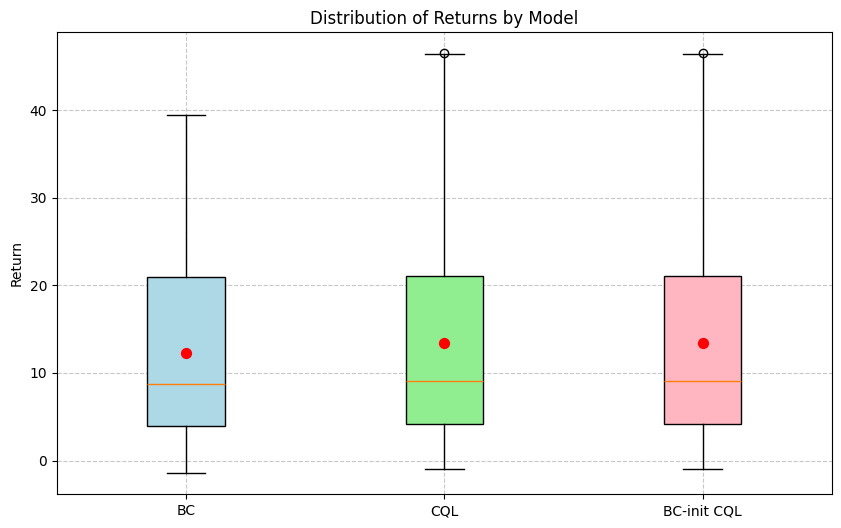

Evaluation complete. Results saved to 'fair_evaluation_returns.npz'


In [ ]:
from scipy import stats
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

"""
Run all three models on same start sequence with discount factor of 0.98
"""
def evaluate_all_models_on_same_states(bc_agent, cql_agent, bc_init_cql_agent, buffer, reward_fn, num_episodes=50, max_steps=80, action_meta_map=None):
    print(f"\nEvaluating {num_episodes} episodes with same starting states for all models:")

    # Create flat mapping for metadata
    flat_idx_to_meta = {}
    if action_meta_map:
        for cat, strategies in action_meta_map.items():
            for strat, levels in strategies.items():
                for lvl, idx in levels.items():
                    flat_idx_to_meta[idx] = {
                        'category': cat,
                        'strategy': strat,
                        'level': lvl
                    }

    # Generate random starting indices for all episodes
    start_indices = np.random.randint(0, len(buffer) - max_steps, size=num_episodes)

    # Initialize arrays to store results
    bc_returns = np.zeros(num_episodes)
    cql_returns = np.zeros(num_episodes)
    bc_init_returns = np.zeros(num_episodes)

    # Evaluate each episode
    for ep_idx, start_idx in enumerate(tqdm(start_indices)):
        # Process same starting state for each model
        for model_idx, (agent, returns_array) in enumerate([
            (bc_agent, bc_returns),
            (cql_agent, cql_returns),
            (bc_init_cql_agent, bc_init_returns)
        ]):
            # Get initial state
            state = buffer.states[start_idx].copy()

            # Initialize episode tracking
            episode_return = 0
            discount = 1.0

            # Run the episode
            for step in range(max_steps):
                # Select action using the policy
                action_idx = agent.select_action(state)

                # Get next state by sampling from buffer
                next_idx = min(start_idx + step + 1, len(buffer) - 1)
                next_state = buffer.states[next_idx].copy()

                # Check for done flag
                done = False
                if hasattr(buffer, 'dones') and len(buffer.dones) > next_idx:
                    done = buffer.dones[next_idx]

                # Get action metadata if available
                action_meta = flat_idx_to_meta.get(action_idx, None)

                # Compute reward
                reward = reward_fn(state, action_idx, next_state, action_meta)

                # Update return
                episode_return += discount * reward
                discount *= 0.98  # Use gamma from training

                # Update state
                state = next_state

                # Check termination conditions
                if done or next_idx >= len(buffer) - 1:
                    break

            # Store the return for this model and episode
            returns_array[ep_idx] = episode_return

    return bc_returns, cql_returns, bc_init_returns

"""
Perform paired t-tests to check for statistical significance
"""
def perform_paired_t_test(bc_returns, cql_returns, bc_init_returns):
    # BC vs CQL
    bc_cql_t, bc_cql_p = stats.ttest_rel(bc_returns, cql_returns)

    # BC vs BC-Init CQL
    bc_init_t, bc_init_p = stats.ttest_rel(bc_returns, bc_init_returns)

    # CQL vs BC-Init CQL
    cql_init_t, cql_init_p = stats.ttest_rel(cql_returns, bc_init_returns)

    print("\nPaired t-test results:")
    print(f"BC vs CQL:          t={bc_cql_t:.4f}, p={bc_cql_p:.4f} {'(significant)' if bc_cql_p < 0.05 else '(not significant)'}")
    print(f"BC vs BC-init CQL:  t={bc_init_t:.4f}, p={bc_init_p:.4f} {'(significant)' if bc_init_p < 0.05 else '(not significant)'}")
    print(f"CQL vs BC-init CQL: t={cql_init_t:.4f}, p={cql_init_p:.4f} {'(significant)' if cql_init_p < 0.05 else '(not significant)'}")

    return {
        'bc_cql': (bc_cql_t, bc_cql_p),
        'bc_init': (bc_init_t, bc_init_p),
        'cql_init': (cql_init_t, cql_init_p)
    }


def plot_returns_comparison(bc_returns, cql_returns, bc_init_returns):
    """
    Create a box plot comparing the return distributions of all models
    """
    plt.figure(figsize=(10, 6))

    data = [bc_returns, cql_returns, bc_init_returns]
    labels = ['BC', 'CQL', 'BC-init CQL']

    box = plt.boxplot(data, patch_artist=True, labels=labels)
    colors = ['lightblue', 'lightgreen', 'lightpink']
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)

    for i, d in enumerate(data):
        plt.scatter(i+1, np.mean(d), marker='o', color='red', s=50, zorder=10)

    plt.ylabel('Return')
    plt.title('Distribution of Returns by Model')
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.savefig('returns_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()


def main():
    # Load trained BC model
    input_dim = 64
    output_dim = 50  # Number of unique actions
    bc_model = BCModel(input_dim=input_dim, output_dim=output_dim)
    bc_model.load_state_dict(torch.load('best_bc_model.pt'))

    # Load data
    csv_file_path = "data.csv"
    train_states, val_states, train_actions, val_actions, num_actions = prepare_data_for_bc(csv_file_path)

    # Define action mappings
    # Original action IDs to model indices (0-49)
    action_map = {0: 0, 1: 1, 2: 2, 3: 3, 5: 4, 6: 5, 7: 6, 8: 7, 11: 8, 12: 9,
                 13: 10, 16: 11, 17: 12, 18: 13, 20: 14, 21: 15, 22: 16, 23: 17,
                 26: 18, 27: 19, 28: 20, 31: 21, 32: 22, 36: 23, 37: 24, 38: 25,
                 41: 26, 42: 27, 43: 28, 45: 29, 46: 30, 47: 31, 48: 32, 54: 33,
                 55: 34, 56: 35, 57: 36, 58: 37, 59: 38, 60: 39, 65: 40, 66: 41,
                 67: 42, 70: 43, 71: 44, 72: 45, 73: 46, 75: 47, 76: 48, 77: 49}

    # Define the metadata map
    action_meta_map = {
        "Focus": {
            "Seek Next Step": {1: 0, 2: 1, 3: 2},
            "Confirm Calculation": {1: 5, 2: 6, 3: 7, 4: 8},
            "Re-direct to Sub-Problem": {2: 11, 3: 12, 4: 13},
            "Highlight Missing Info": {2: 16, 3: 17, 4: 18}
        },
        "Probing": {
            "Ask for Explanation": {1: 20, 2: 21, 3: 22, 4: 23},
            "Seek Self-Correction": {2: 26, 3: 27, 4: 28},
            "Hypothetical Variation": {2: 31, 3: 32},
            "Check Understanding/Concept": {2: 36, 3: 37, 4: 38},
            "Encourage Comparison": {2: 41, 3: 42, 4: 43}
        },
        "Telling": {
            "Partial Reveal (Strategy)": {1: 45, 2: 46, 3: 47, 4: 48},
            "Full Reveal (Answer)": {1: 54, 2: 55, 3: 56, 4: 57, 5: 58, 6: 59},
            "Corrective Explanation": {1: 60}
        },
        "Generic": {
            "Acknowledgment/Praise": {1: 65, 2: 66, 3: 67},
            "Summarize Progress": {1: 70, 2: 71, 3: 72, 4: 73},
            "General Inquiry/Filler": {1: 75, 2: 76, 3: 77}
        }
    }

    # Load dataframe for the transition buffer
    df = pd.read_csv(csv_file_path)

    # Build the transition buffer with enhanced reward function
    buffer, returned_action_map = build_transition_buffer(
        df=df,
        reward_fn=hybrid_reward,
        meta_map=action_meta_map,
        orig_to_idx=action_map,
        episode_column=None
    )

    # Print buffer statistics
    print(f"\nTransition Buffer Statistics:")
    print(f"Total transitions: {len(buffer)}")
    print(f"State dimension: {buffer.states.shape[1]}")
    print(f"Number of unique actions: {len(set(buffer.actions))}")

    # Check if models are already trained (if not, train them)
    try:
        # Try to load the CQL models
        cql_agent = CQLAgent(state_dim=buffer.states.shape[1], action_dim=output_dim)
        cql_agent.load('best_cql_model.pt')

        bc_init_cql_agent = CQLAgent(state_dim=buffer.states.shape[1], action_dim=output_dim)
        bc_init_cql_agent.load('best_initialized_cql_model.pt')

        print("Successfully loaded pre-trained models.")
    except:
        print("Could not load models. Training from scratch...")

        # Option 1: Train CQL from scratch
        print("\nTraining CQL from scratch...")
        cql_agent = train_cql(
            buffer=buffer,
            state_dim=buffer.states.shape[1],
            action_dim=output_dim,
            num_epochs=100,
            batch_size=256,
            hidden_dim=256,
            lr=1e-4,
            gamma=0.98,
            tau=0.005,
            cql_alpha=2.0,
            model_save_path='best_cql_model.pt',
            action_map=action_map,
            action_meta_map=action_meta_map
        )

        # Option 2: Initialize CQL with BC weights
        print("\nTraining BC-initialized CQL...")
        bc_initialized_cql = convert_bc_to_cql_model(bc_model, output_dim)
        bc_initialized_cql.save('bc_initialized_cql.pt')

        bc_init_cql_agent = train_cql(
            buffer=buffer,
            state_dim=buffer.states.shape[1],
            action_dim=output_dim,
            num_epochs=30,
            batch_size=256,
            hidden_dim=256,
            lr=3e-5,
            gamma=0.98,
            tau=0.005,
            cql_alpha=0.9,
            model_save_path='best_initialized_cql_model.pt',
            action_map=action_map,
            action_meta_map=action_meta_map
        )

    # Wrap BC for consistent interface
    bc_agent = BCPolicyWrapper(bc_model, action_map, device=cql_agent.device)

    # Evaluate all models on the same starting states
    print("\nEvaluating models on same starting states...")
    bc_returns, cql_returns, bc_init_returns = evaluate_all_models_on_same_states(
        bc_agent=bc_agent,
        cql_agent=cql_agent,
        bc_init_cql_agent=bc_init_cql_agent,
        buffer=buffer,
        reward_fn=hybrid_reward,
        num_episodes=100,  # Increased for better statistical significance
        max_steps=60,
        action_meta_map=action_meta_map
    )

    # Calculate means and standard deviations
    bc_mean = np.mean(bc_returns)
    cql_mean = np.mean(cql_returns)
    bc_init_mean = np.mean(bc_init_returns)

    bc_std = np.std(bc_returns)
    cql_std = np.std(cql_returns)
    bc_init_std = np.std(bc_init_returns)

    # Print comparison
    print("\nModel Comparison (fair evaluation):")
    print(f"BC policy return:            {bc_mean:.4f} ± {bc_std:.4f}")
    print(f"Standard CQL policy return:  {cql_mean:.4f} ± {cql_std:.4f} ({(cql_mean-bc_mean)/abs(bc_mean)*100:.1f}% vs BC)")
    print(f"BC-init CQL policy return:   {bc_init_mean:.4f} ± {bc_init_std:.4f} ({(bc_init_mean-bc_mean)/abs(bc_mean)*100:.1f}% vs BC)")

    # Perform paired t-tests
    test_results = perform_paired_t_test(bc_returns, cql_returns, bc_init_returns)

    # Plot return distributions
    plot_returns_comparison(bc_returns, cql_returns, bc_init_returns)

    # Save returns for future analysis
    np.savez('fair_evaluation_returns.npz',
             bc_returns=bc_returns,
             cql_returns=cql_returns,
             bc_init_returns=bc_init_returns)

    print("Evaluation complete. Results saved to 'fair_evaluation_returns.npz'")


if __name__ == "__main__":
    main()